# DataCamp Certification Case Study

### Project Brief

You have been hired as a data scientist at a used car dealership in the UK. The sales team have been having problems with pricing used cars that arrive at the dealership and would like your help. Before they take any company wide action they would like you to work with the Toyota specialist to test your idea. They have already collected some data from other retailers on the price that a range of Toyota cars were listed at. It is known that cars that are more than £1500 above the estimated price will not sell. The sales team wants to know whether you can make predictions within this range.

The presentation of your findings should be targeted at the Head of Sales, who has no technical data science background.

The data you will use for this analysis can be accessed here: `"data/toyota.csv"`

# Data Loading, Summarization, and Analysis

In [1]:
# Data loading
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format

# Create DataFrame
used_car_sales = pd.read_csv('data/toyota.csv')

# Quick look at random rows of dataset
display(used_car_sales.sample(5))

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
3926,Aygo,2017,5790,Manual,26333,Petrol,0,69.00,1.00
1770,Yaris,2017,8888,Manual,21692,Petrol,30,58.00,1.30
3416,Auris,2014,7625,Manual,39771,Petrol,145,46.30,1.60
2518,Yaris,2018,12995,Automatic,17577,Hybrid,135,76.30,1.50
1113,Yaris,2014,5495,Manual,52354,Diesel,0,72.40,1.40


In [2]:
# Dataset summary
print(used_car_sales.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6738 entries, 0 to 6737
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         6738 non-null   object 
 1   year          6738 non-null   int64  
 2   price         6738 non-null   int64  
 3   transmission  6738 non-null   object 
 4   mileage       6738 non-null   int64  
 5   fuelType      6738 non-null   object 
 6   tax           6738 non-null   int64  
 7   mpg           6738 non-null   float64
 8   engineSize    6738 non-null   float64
dtypes: float64(2), int64(4), object(3)
memory usage: 473.9+ KB
None


In [3]:
# Determine value counts for categorical features, model, transmission, fuelType
print(used_car_sales['fuelType'].value_counts())

Petrol    4087
Hybrid    2043
Diesel     503
Other      105
Name: fuelType, dtype: int64


In [4]:
# Encode categorical features

used_car_sales['transmission'] = used_car_sales['transmission'].replace({'Manual': 1, 'Automatic': 2, 
                                                           'Semi-Auto': 3, 'Other': 4})
used_car_sales['fuelType'] = used_car_sales['fuelType'].replace({'Petrol': 1, 'Hybrid': 2, 
                                                       'Diesel': 3, 'Other': 4})



In [5]:
print(used_car_sales['fuelType'].value_counts())

1    4087
2    2043
3     503
4     105
Name: fuelType, dtype: int64


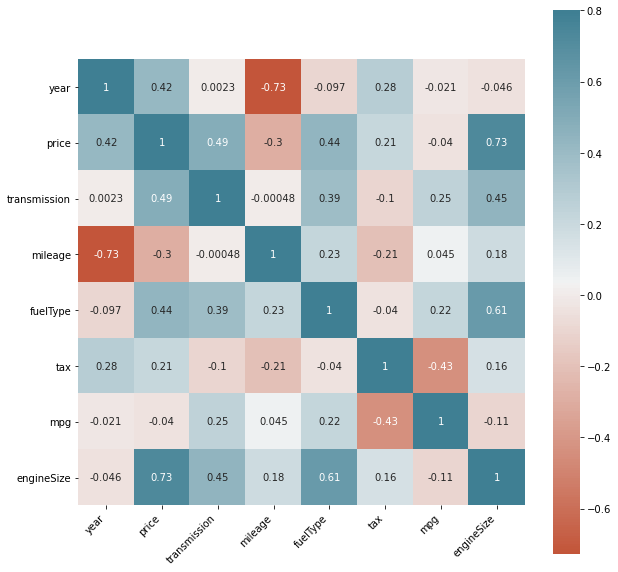

In [6]:
# Correlation matrix/heatmap
import matplotlib.pyplot as plt
import seaborn as sns

correlation = used_car_sales.corr()
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(correlation, vmax=.8,
            annot=True,
            cmap=sns.diverging_palette(20, 220, n=200), 
            square=True)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right');

'price' correlates highest with 'engineSize' (0.73), 'transmission' (0.49), 'fuelType' (0.44), and 'year' (0.42). A correlation of 0.44 and 0.42 are not very high, but they still show that there is a relationship. There's a negative correlation between 'price' and 'mileage' (-0.30) that is not significantly strong, but is notable. This makes sense on an intuitive level.

<Figure size 432x288 with 0 Axes>

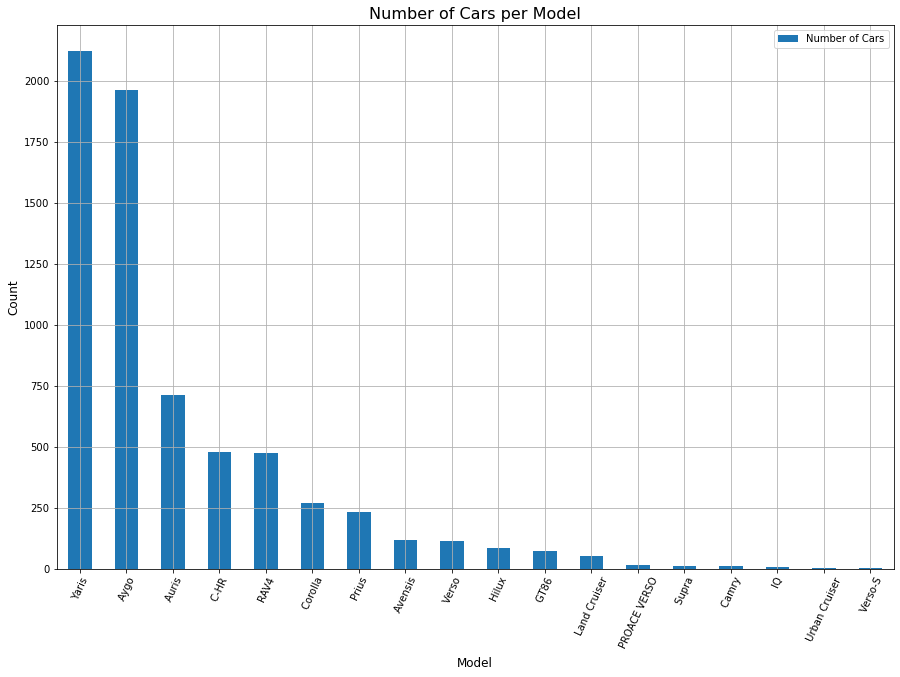

In [7]:
# Close look at number of each 'model'
car_models = pd.DataFrame(used_car_sales['model'].value_counts().reset_index().values, columns = ['Model', 'Number of Cars'])
car_models = car_models.sort_index(axis = 0, ascending=True)
#display(car_models.head())

# Create x-axis labels
x_labels = list(car_models['Model'])

# Plot histogram
plt.figure()
ax = car_models.plot.bar(figsize=(15, 10), grid=True, fontsize=10)

# Title and axis names
ax.set_title('Number of Cars per Model', fontsize=16)
ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_xticklabels(x_labels, rotation=65)

# Show graph
plt.show()

# Preprocessing

/Users/paperscissoroxie/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Normal'}, xlabel='price', ylabel='Density'>

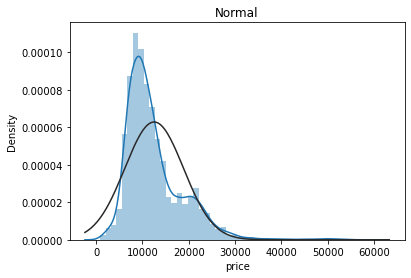

In [8]:
# Check for normality
from scipy import stats

target = used_car_sales['price']

plt.figure(1); plt.title('Normal')
sns.distplot(target, kde=True, fit=stats.norm)

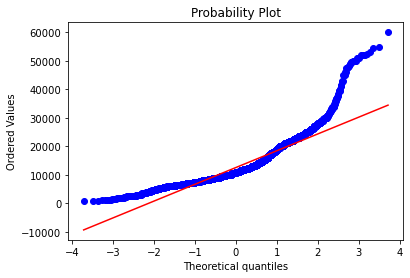

In [9]:
# Probability plot
res = stats.probplot(target, plot=plt)

The price variable is not normally distributed. Linear regression assumes normal distribution, so the data will need to be transformed before performing regression. The distribution skews to the right. Log transformation can smooth out the data, remove the skew, and make the distribution more 'normal', which will allow for the statistical analysis results from these data be more valid. 

In [10]:
# Log transformation
import numpy as np

used_car_sales['price'] = np.log(used_car_sales['price'])

/Users/paperscissoroxie/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


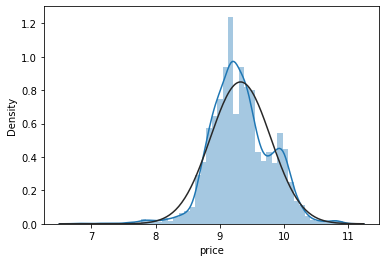

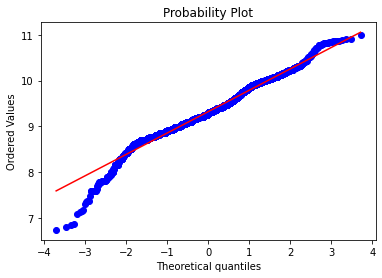

In [11]:
# Visualize transformed histogram and normal probability plot
target = used_car_sales['price']

sns.distplot(target, fit=stats.norm)
plt.figure()

res = stats.probplot(target, plot=plt)

# Linear Regression

In [12]:
# Preparing data for modeling

# Create DataFrame with features only
used_car_sales_f = used_car_sales.copy()
used_car_sales_f.drop(['price', 'model'], inplace = True, axis = 1)

# Segregate features and labels into separate variables
X,y = used_car_sales_f, used_car_sales['price']

print('Number of independent variables: ' + str(X.shape[1]))
print()

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV

# Standardize features
std = StandardScaler()
X = std.fit_transform(X)

# Partition the dataset in train + validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

print('X_train : ' + str(X_train.shape))
print('X_test : ' + str(X_test.shape))
print('y_train : ' + str(y_train.shape))
print('y_test : ' + str(y_test.shape))

Number of independent variables: 7

X_train : (4716, 7)
X_test : (2022, 7)
y_train : (4716,)
y_test : (2022,)


In [13]:
# RMSE
def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv = 5))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring='neg_mean_squared_error', cv = 5))
    return(rmse)

RMSE on Train set : 0.168
RMSE on Test set : 0.175

The coefficient of determination calculated by the linear regression : 0.87
The intercept calculated by the linear regression : 9.32
The coefficients calculated by the linear regression :

               Coefficient
year                 0.21
transmission         0.08
mileage             -0.09
fuelType             0.03
tax                 -0.02
mpg                  0.01
engineSize           0.30


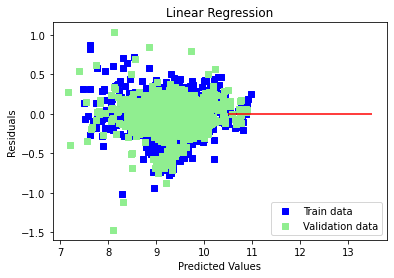

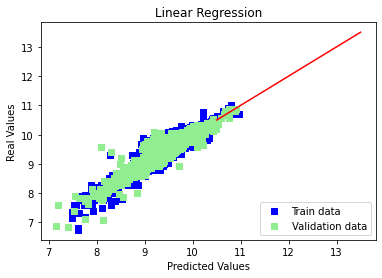

In [14]:
# Linear Regression

# Training the algorithm
lr = LinearRegression().fit(X_train, y_train)

# Look at predictions on training and validation set
print('RMSE on Train set : {0:0.3f}'.format(rmse_cv_train(lr).mean()))
print('RMSE on Test set : {0:0.3f}'.format(rmse_cv_test(lr).mean()))

# Print the coefficient of determination
r_sq = lr.score(X_train, y_train)
print('\nThe coefficient of determination calculated by the linear regression : {0:0.2f}'.format(r_sq))

# Print intercept and coefficients
lr_int = lr.intercept_
print('The intercept calculated by the linear regression : {0:0.2f}'.format(lr_int))
lr_coef = pd.DataFrame(lr.coef_, used_car_sales_f.columns, columns=['Coefficient'])
print('The coefficients calculated by the linear regression :\n\n', lr_coef)
#print('The coefficients calculated by the linear regression :', (*['{0:0.2f}'.format(i) for i in lr_coef]))

y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

# Plot residuals
plt.scatter(y_train_pred, y_train_pred - y_train, c = 'blue', marker = 's', label = 'Train data')
plt.scatter(y_test_pred, y_test_pred - y_test, c = 'lightgreen', marker = 's', label = 'Validation data')
plt.title('Linear Regression')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.legend(loc = 'lower right')
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = 'red')
plt.show()

# Plot predictions
plt.scatter(y_train_pred, y_train, c = 'blue', marker = 's', label = 'Train data')
plt.scatter(y_test_pred, y_test, c = 'lightgreen', marker = 's', label = 'Validation data')
plt.title('Linear Regression')
plt.xlabel('Predicted Values')
plt.ylabel('Real Values')
plt.legend(loc = 'lower right')
plt.plot([10.5, 13.5], [10.5, 13.5], c = 'red')
plt.show()

The coefficient of determination is pretty large (close to 1), which could indicate the model is performing well. A large coefficient of determination could be a sign of overfitting. The RMSE scores for both the train and test data are small, which is a good sign, and the two scores are very close to each other showing that the model is not over- or under-fitting. 

In [15]:
# Make some predictions

y_pred = lr.predict(X_test)

In [16]:
# Compare actual output values for 'X_test' with predicted values

act_v_pred = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
act_v_pred

,Actual,Predicted
2527,9.33,9.35
134,9.85,9.34
4844,9.10,9.20
3638,9.21,9.18
98,9.68,9.33
...,...,...
38,9.62,9.44
158,9.90,9.32
1302,9.55,9.55
4801,9.14,8.99


The model was used to predict new values and compared to actual values. The predicted and actual values are close to each other. Further assessment of the evaluation of the model performance is produced below.

In [17]:
# Evaluate algorithm
from sklearn import metrics

print('Mean Absolute Error : {0:0.2f}'.format(metrics.mean_absolute_error(y_test, y_pred)))
print('Mean Squared Error : {0:0.2f}'.format(metrics.mean_squared_error(y_test, y_pred)))
print('Root Mean Squared Error : {0:0.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))

used_car_sales['price'].describe().round(2)

Mean Absolute Error : 0.12
Mean Squared Error : 0.03
Root Mean Squared Error : 0.17


count   6738.00
mean       9.32
std        0.47
min        6.75
25%        9.02
50%        9.29
75%        9.62
max       11.00
Name: price, dtype: float64

The value of the RMSE is 0.17, less than 10% of the mean value of the price, 9.32, which shows that the model is performing well.

Log transformation was performed on the data used to train the model. Back transformation must be performed on the predicted values to express them on the same scale as the original data by applying the inverse of the original transformation.

In [18]:
# Back transform
y_pred = np.exp(y_pred)
y_test = np.exp(y_test)

In [19]:
# Compare actual output values for 'X_test' with predicted values

act_v_pred = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
act_v_pred

,Actual,Predicted
2527,11295.00,11485.06
134,18995.00,11357.66
4844,8950.00,9904.98
3638,9995.00,9711.39
98,15990.00,11244.49
...,...,...
38,15000.00,12578.51
158,19990.00,11183.43
1302,13988.00,14030.07
4801,9296.00,8059.70


In [20]:
act_v_pred['Difference'] = act_v_pred['Predicted'] - act_v_pred['Actual']

In [21]:
act_v_pred

,Actual,Predicted,Difference
2527,11295.00,11485.06,190.06
134,18995.00,11357.66,-7637.34
4844,8950.00,9904.98,954.98
3638,9995.00,9711.39,-283.61
98,15990.00,11244.49,-4745.51
...,...,...,...
38,15000.00,12578.51,-2421.49
158,19990.00,11183.43,-8806.57
1302,13988.00,14030.07,42.07
4801,9296.00,8059.70,-1236.30


In [22]:
act_v_pred['Unsellable'] = act_v_pred['Difference'].ge(1500)

In [23]:
act_v_pred

,Actual,Predicted,Difference,Unsellable
2527,11295.00,11485.06,190.06,False
134,18995.00,11357.66,-7637.34,False
4844,8950.00,9904.98,954.98,False
3638,9995.00,9711.39,-283.61,False
98,15990.00,11244.49,-4745.51,False
...,...,...,...,...
38,15000.00,12578.51,-2421.49,False
158,19990.00,11183.43,-8806.57,False
1302,13988.00,14030.07,42.07,False
4801,9296.00,8059.70,-1236.30,False


In [24]:
print('Predictions that exceed estimated price by more than $1,500 : \n\n', 
      act_v_pred[act_v_pred['Unsellable'] == True])

Predictions that exceed estimated price by more than $1,500 : 

        Actual  Predicted  Difference  Unsellable
4434  9991.00   11967.22     1976.22        True
1869  9750.00   11758.18     2008.18        True
6576 20500.00   26107.15     5607.15        True
891  10695.00   12298.65     1603.65        True
2795 11991.00   14063.62     2072.62        True
...       ...        ...         ...         ...
1259 12788.00   14460.10     1672.10        True
862  11747.00   13253.47     1506.47        True
2518 12995.00   14527.16     1532.16        True
4189  7980.00   10351.34     2371.34        True
3042 10888.00   12594.94     1706.94        True

[333 rows x 4 columns]
